In [1]:
# Load toolkit and initialize parallel computation (3 clients) if required
research_directory = %pwd
research_directory += '/..'
tools_script = research_directory + '/Tools.ipynb'
from ipyparallel import Client
rc = Client(); dview = rc[:]
if len(dview) != 3: raise RuntimeError('Want to have 3 parallel clients.')
for i in range(3): rc[i]['ID'] = i
dview['research_directory'] = research_directory
%px %run $tools_script
%run $tools_script

In [2]:
%%px
def selectOom(dim, nO, exponent, zero_threshold = 1e-7, rand = None, k = 3, tries = 50, lTest = 10**5):
    """Return a randomly generated Oom of dimension `dim` and alphabetsize `nO` generated with the given `exponent`
    and `zero_threshold`. Of `tries` number of such Ooms, select the one that is farthest from a `k`-order
    Markov model measured by the KL divergence on a test sample of length `lTest`."""
    if rand is None: rand = tom.Random()
    maxKL = -np.inf
    oom = None
    for i in range(tries):
        cand = tom.Oom(dim, nO, 0, np.double(exponent), np.double(zero_threshold), rand)
        tt = cand.sample(lTest, rand); cand.reset()
        KL = cand.crossEntropyOfKOrderMarkovApproximation(k, tt) - cand.l2l(tt)
        if KL > maxKL:
            maxKL = KL
            oom = cand
    oom.reset()
    return oom, maxKL
def tryOomExponents(dim, nO, exponents, rand = None, lTest = 10**7):
    if rand is None: rand = tom.Random()
    entropies_oom_0MM_3MM = np.zeros((3, len(exponents)))
    ooms = []
    for idx, exponent in enumerate(exponents):
        oom, max_KL = selectOom(dim, nO, exponent, rand = rand)
        seq = oom.sample(lTest, rand)
        entropies_oom_0MM_3MM[0, idx] = oom.l2l(seq)
        entropies_oom_0MM_3MM[1, idx] = oom.crossEntropyOfKOrderMarkovApproximation(0, seq)
        entropies_oom_0MM_3MM[2, idx] = oom.crossEntropyOfKOrderMarkovApproximation(3, seq)
        ooms.append(oom)
    return entropies_oom_0MM_3MM, ooms

In [3]:
parameters = [ # entries (dim, nO, exponents)
    ( 7,  4, np.r_[1:102:3]),
    (32,  4, np.r_[0:301:10]),
    ( 7, 27, np.r_[1:102:3]),
    (32, 27, np.r_[0:301:10])]

In [4]:
# Compute the entropies data and corresponding OOMs (~1:30 h)
np.random.seed(123456789)
for client in rc: client['seed'] = np.random.randint(0, 2**31-1)
%px rand = tom.Random(seed)
dview['parameters'] = parameters
%px entropies = {}
%px for dim, nO, exponents in parameters: entropies[(dim, nO)] = tryOomExponents(dim, nO, exponents, rand)
entropies_and_ooms = dview['entropies']

In [5]:
# Select the ooms
px_entropies = entropies_and_ooms
entropies = {}
ooms = {}
for dim, nO, exponents in parameters:
    best = []
    for exi, ex in enumerate(exponents):
        best.append(np.argsort([e[(dim, nO)][0][0, exi] for e in px_entropies])[0])
        if (dim == 7 and ex == 40) or (dim == 32 and ex == 160):
            ooms[(dim, nO)] = entropies_and_ooms[best[exi]][(dim, nO)][1][exi]
    entropies[(dim, nO)] = np.array([[e[(dim, nO)][0] for e in px_entropies][best[exi]][:,exi] for exi, ex in enumerate(exponents)]).transpose()

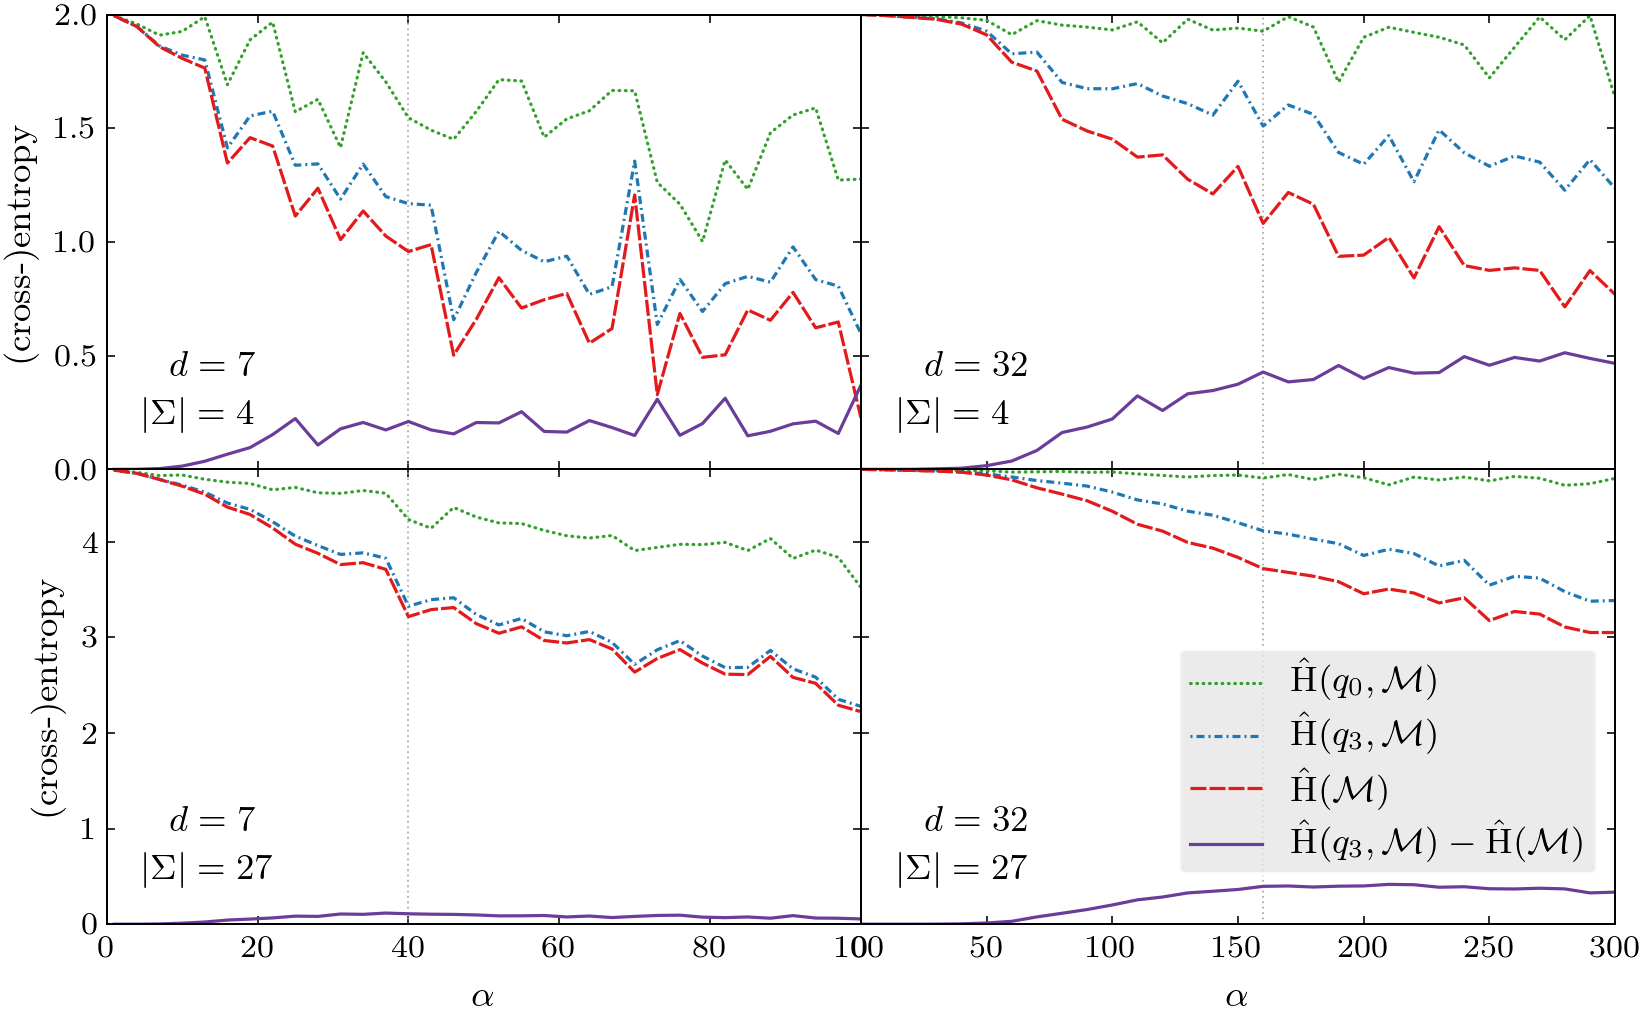

In [10]:
# Generate plot for Figure 5.1 (fig::randoom)
plt.figure(dpi=144)
for i, (dim, nO, exponents) in enumerate(parameters):
    ax = plt.subplot(2, 2, i+1)
    #plt.axes(frameon=0)
    #plt.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    style = myStyle(lw=0.5, color='grey', ls = 1)
    plt.axvline(x = 40 if exponents[-1] == 100 else 160, **style)

    style = myStyle(lw=1, color='green', ls = 1)    
    line, = plt.plot(exponents, entropies[(dim, nO)][1, :], #entropies_std[(dim, nO)][1, :],
                     **style)
    style = myStyle(lw=1, color='blue', ls = 3)        
    line.set_label(r'\noindent $\hat{\rm{H}}(q_0, \mathcal{M})$')
    line, = plt.plot(exponents, entropies[(dim, nO)][2, :], #entropies_std[(dim, nO)][2, :],
                     **style)
    style = myStyle(lw=1, color='red', ls = 4)    
    line.set_label(r'\noindent $\hat{\rm{H}}(q_3, \mathcal{M})$')
    line, = plt.plot(exponents, entropies[(dim, nO)][0, :], #entropies_std[(dim, nO)][0, :],
                     **style)
    style = myStyle(lw=1, color='purple', ls = 0)    
    line.set_label(r'\noindent $\hat{\rm{H}}(\mathcal{M})$')
    line, = plt.plot(exponents, entropies[(dim, nO)][2, :] - entropies[(dim, nO)][0, :],
                     **style)
    line.set_label(r'\noindent $\hat{\rm{H}}(q_3, \mathcal{M}) - \hat{\rm{H}}(\mathcal{M})$')
    plt.text(15/3 if exponents[-1] == 100 else 15, np.log2(nO)/10, r'\noindent $\;\;\:d=%d $ \\ $|\Sigma|= %d $' % (dim,nO))
    if i > 1: plt.xlabel(r'$\alpha$')
    plt.ylim(0, np.log2(nO))
    plt.xlim(0, 100 if exponents[-1] == 100 else 300)
    if i == 0 or i == 2: plt.ylabel('(cross-)entropy')
    if i in [1,3]: ax.set_yticklabels([])
    if i in [0,1]: ax.set_xticklabels([])
legend = plt.legend(loc=4, bbox_to_anchor=(1, 0.07))
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('1.0')
finishPlot()
savePlot('oom_benchmark_selection')

In [7]:
# Get the benchmark OOMs
r4_7 = ooms[(7, 4)]; tom.save(r4_7, 'RANDOM4_7.oom')
r4_32 = ooms[(32, 4)]; tom.save(r4_32, 'RANDOM4_32.oom')
r27_7 = ooms[(7, 27)]; tom.save(r27_7, 'RANDOM27_7.oom')
r27_32 = ooms[(32, 27)]; tom.save(r27_32, 'RANDOM27_32.oom')

In [8]:
def compute_sparsity(oom, threshold = 1e-7):
    is_zero = 0
    for o in range(oom.nOutputSymbols()):
        for u in range(max(1, oom.nInputSymbols())):
            is_zero += np.sum(oom.tau(o,u) <= threshold)
    return is_zero / (oom.nOutputSymbols() * max(1, oom.nInputSymbols()) * oom.dimension()**2)
def check_valid(oom):
    tau = sum([oom.tau(o) for o in range(oom.nOutputSymbols())])
    if not np.allclose(oom.sig().dot(oom.w0()), 1): return False
    if not np.allclose(oom.sig().dot(tau), oom.sig()): return False
    if not np.allclose(tau.dot(oom.w0()), oom.w0()): return False
    return True

In [9]:
# Compute various properties of the generated OOMs
for oomName in ['RANDOM4_7', 'RANDOM4_32', 'RANDOM27_7', 'RANDOM27_32']:
    rand = tom.Random(123456789)
    print(oomName)
    bd = BenchData(oomName)
    oom = bd.oom
    tests = [bd.getSequence(id, use='test') for id in range(5)]
    print("   Valid:", check_valid(oom))
    print("   Sparsity: %f" % compute_sparsity(oom))
    print("   log_2(|S|): %f" % np.log2(oom.nOutputSymbols()))
    e = []
    for k in range(4):
        e.append(sum([oom.crossEntropyOfKOrderMarkovApproximation(k, ts) for ts in tests])/len(tests))
        print("   Cross-entropy for %d-order Markov model: %f" % (k, e[-1]))
    e.append(oom.entropy(10**7, rand))
    print("   Entropy estimated by bz2 compression:      %f" % (sum([8 * len(bz2.compress(bytes(ts.toJSON(), 'UTF-8')))/ts.length() for ts in tests])/len(tests)))
    ent = np.average([oom.l2l(ts) for ts in tests])
    print("   Entropy estimated on test sequences:       %f" % ent)
    print("   Entropy estimated by `oom.entropy(10**7)`: %f" % e[-1])
    print('   [' + ', '.join('%.5f' % x for x in e) + ']')

RANDOM4_7
   Valid: True
   Sparsity: 0.663265
   log_2(|S|): 2.000000
   Cross-entropy for 0-order Markov model: 1.545320
   Cross-entropy for 1-order Markov model: 1.437657
   Cross-entropy for 2-order Markov model: 1.314549
   Cross-entropy for 3-order Markov model: 1.169334
   Entropy estimated by bz2 compression:      1.293392
   Entropy estimated on test sequences:       0.958573
   Entropy estimated by `oom.entropy(10**7)`: 0.957427
   [1.54532, 1.43766, 1.31455, 1.16933, 0.95743]
RANDOM4_32
   Valid: True
   Sparsity: 0.901123
   log_2(|S|): 2.000000
   Cross-entropy for 0-order Markov model: 1.926944
   Cross-entropy for 1-order Markov model: 1.884874
   Cross-entropy for 2-order Markov model: 1.716046
   Cross-entropy for 3-order Markov model: 1.513139
   Entropy estimated by bz2 compression:      1.511936
   Entropy estimated on test sequences:       1.084730
   Entropy estimated by `oom.entropy(10**7)`: 1.080929
   [1.92694, 1.88487, 1.71605, 1.51314, 1.08093]
RANDOM27_7
  